# Selection of network depth and number of filters for the model

## Contents
* [Task description](#Task-description)
* [Model description](#Model-description)
* [The parameters studied](#The-parameters-studied)
* [Parameters Value Area](#Parameters-Value-Area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Creating a cross validation objects](#Creating-a-cross-validation-objects)
    * [Frist research](#Frist-research)
    * [Second research](#Second-research)
* [Results](#Results)
* [Conclusion](#Conclusion)

## Task description
Select the architecture parameters of CNN, that predicts radial mode value. This parameters will be selected using research and cross validation method.

## Model description

This is a small variation of ResNet architecture. The model consists following parameters:

3 standard ResNet blocks with max pooling at the start. Using layout notation one block can be written as `Rcna cna+` where:

* R - start residual connection
* `+` - end residual connection with summation

start number of parameters equal `8`.

max pooling parameters:
* pool_size = 3
* pool_stride = 2

parameters of each block:
* number of filters = [4, 8, 16]
* actiavtion = tf.relu
* kernel_size = 3
* strides = 2
* padding = 'same'

## The parameters studied
The order of the channels, number of initial filters, number of filters inside blocks.

## Parameters Value Area

ResNet-like models have established themself in the industry as one of the most reliable models. So we decided that it would be more practical to use ResNet and focus on choosing the optimal parameters. To find the optimal parameters, we have tested two types of ResNet-like models. The first model has 2 ResNet blocks and the second one has 3 ResNet blocks. It makes no sense to use model with 1 ResNet block, because model is too small and models with 4 ResNet blocks is too big. Following parameters was checked during the research:

First Research:

* Number of initial filters: $2, 4, 8$

* Number of filters inside blocks: $[2, 4],\\ [4, 8],\\ [8, 16]$

* Number of ResNet blocks in a row: $[1, 1],\\ [2, 2]$

Second Research:

* Number of initial filters: $2, 4, 8$

* Number of filters inside blocks: $[2, 4, 8],\\ [4, 8, 16],\\ [8, 16, 32]$

* Number of ResNet blocks in a row: $[1, 1, 1],\\ [2, 2, 2]$

We have not checked models with many filters or blocks because experiments have shown that models with few filters and blocks works better.  

## Metrics

A percentage of items with absolute percentage error less than 30% on the test set i.e. `test_mape30`

## Dataset loading

For training and model performance assessment we use pressure derivative from wells.

Dataset consists of two parts: train (311 items) and test (90 items).

With cross validation approach we will mix all data and split it into peases for training and testing.

In [1]:
import os
import sys
sys.path.insert(0, os.path.join(".."))

import numpy as np
import matplotlib.pyplot as plt

from radial.batchflow import Dataset, FilesIndex, C
from radial.batchflow.models.tf import ResNet

from radial.batchflow.research import Research, Option

from radial.core.radial_batch_tools import get_mape30, save_model, get_ape
from radial.core import RadialBatch

from radial.pipelines import *

from research_utils import (draw_history, draw_hisogram, print_results_cv,
                            create_datasets, execute_research_with_cv,
                            print_results_research)

plt.style.use('ggplot')
%matplotlib inline

In [2]:
cross_val = 5
path = "./data_isol/*"

dataset = create_datasets(path, RadialBatch, cross_val)

## Dataset bypass:

- Define batch and grid size
- Define model config

In [3]:
N_SAMPLES = 100

model_config = {
    'inputs': dict(points=dict(shape=(N_SAMPLES, 2)),
                   targets=dict(name='target', shape=1)),
    'initial_block/inputs': 'points',
    'head': dict(layout='f',
                 units=1),
    'body/num_blocks': C('num_blocks'),
    'body/filters': C('body_filters'),
    'initial_block/filters': C('start_filters'),
    'loss': 'mse',
    'optimizer': 'Adam'
}

- Define a preprocessing pipeline that will be shared between train and test pipelines
- Define train and test pipeline

In [4]:
B_SIZE = 50

prep_pipeline = create_preprocess_pipeline(N_SAMPLES, np.random.random)
train_pipeline = create_train_pipeline(ResNet, model_config,
                                       prep_pipeline).run(B_SIZE, n_epochs=None, 
                                                          drop_last=True, lazy=True)

test_pipeline = create_predict_pipeline(prep=prep_pipeline, 
                                        load_model=C('import_from')).run(B_SIZE, n_epochs=1, 
                                                                         drop_last=True,
                                                                         lazy=True)

## Creating a cross validation objects
Cross validation algorithm depend on research object, so let's configurate first research.

### Frist research

In [5]:
opts = (Option('num_blocks', [[1, 1],
                               [2, 2]]) * 
       Option('body_filters', [[2, 4],
                               [4, 8],
                               [8, 16]]) * 
       Option('start_filters', [2, 4, 8]))

research = (Research()
            .add_pipeline(train_pipeline, variables='loss', name='train')
            .add_pipeline(test_pipeline, name='test', execute='%5',
                          run=True, import_from='train')
            .add_grid(opts)
            .add_function(get_mape30, returns='metrics', name='test_mape30',
                          execute='%5', pipeline='test')
            .add_function(get_ape, returns='metrics', name='test_ape',
                          execute=-1, pipeline='test')
            .add_function(save_model, execute=-1, pipeline='train',
                          model_name='model', path='saved_models/')
)

Now you can run first cross validation.

In [6]:
res = execute_research_with_cv(train_pipeline, test_pipeline, research,
                               dataset, n_reps=5, n_iters=1500, 
                               cross_val=cross_val, dir_name='research_2_block',
                               workers=3, gpu=[5, 6, 7])

### Second research
It is time to create second cross validation instance. As usual, firstly you should configurate research object.

In [7]:
opts = (Option('num_blocks', [[1, 1, 1],
                              [2, 2, 2]]) * 
       Option('body_filters', [[2, 4, 8],
                               [4, 8, 16],
                               [8, 16, 32]]) * 
       Option('start_filters', [2, 4, 8]))

research = (Research()
            .add_pipeline(train_pipeline, variables='loss', name='train')
            .add_pipeline(test_pipeline, name='test', execute='%5',
                          run=True, import_from='train')
            .add_grid(opts)
            .add_function(get_mape30, returns='metrics', name='test_mape30',
                          execute='%5', pipeline='test')
            .add_function(get_ape, returns='metrics', name='test_ape',
                          execute=-1, pipeline='test')
            .add_function(save_model, execute=-1, pipeline='train',
                          model_name='model', path='saved_models/')
)

Now you can run second cross validation.

In [8]:
res = execute_research_with_cv(train_pipeline, test_pipeline, research,
                               dataset, n_reps=5, n_iters=1500, 
                               cross_val=cross_val, dir_name='research_3_block',
                               workers=5, gpu=[0, 1, 2, 3, 4])

## Results

To analyze of the results, first let's draw graphs of metric changes during the first research. ForTo keep things clear, let's draw only part of the results with ```num_blocks = [1, 1, 1]```.

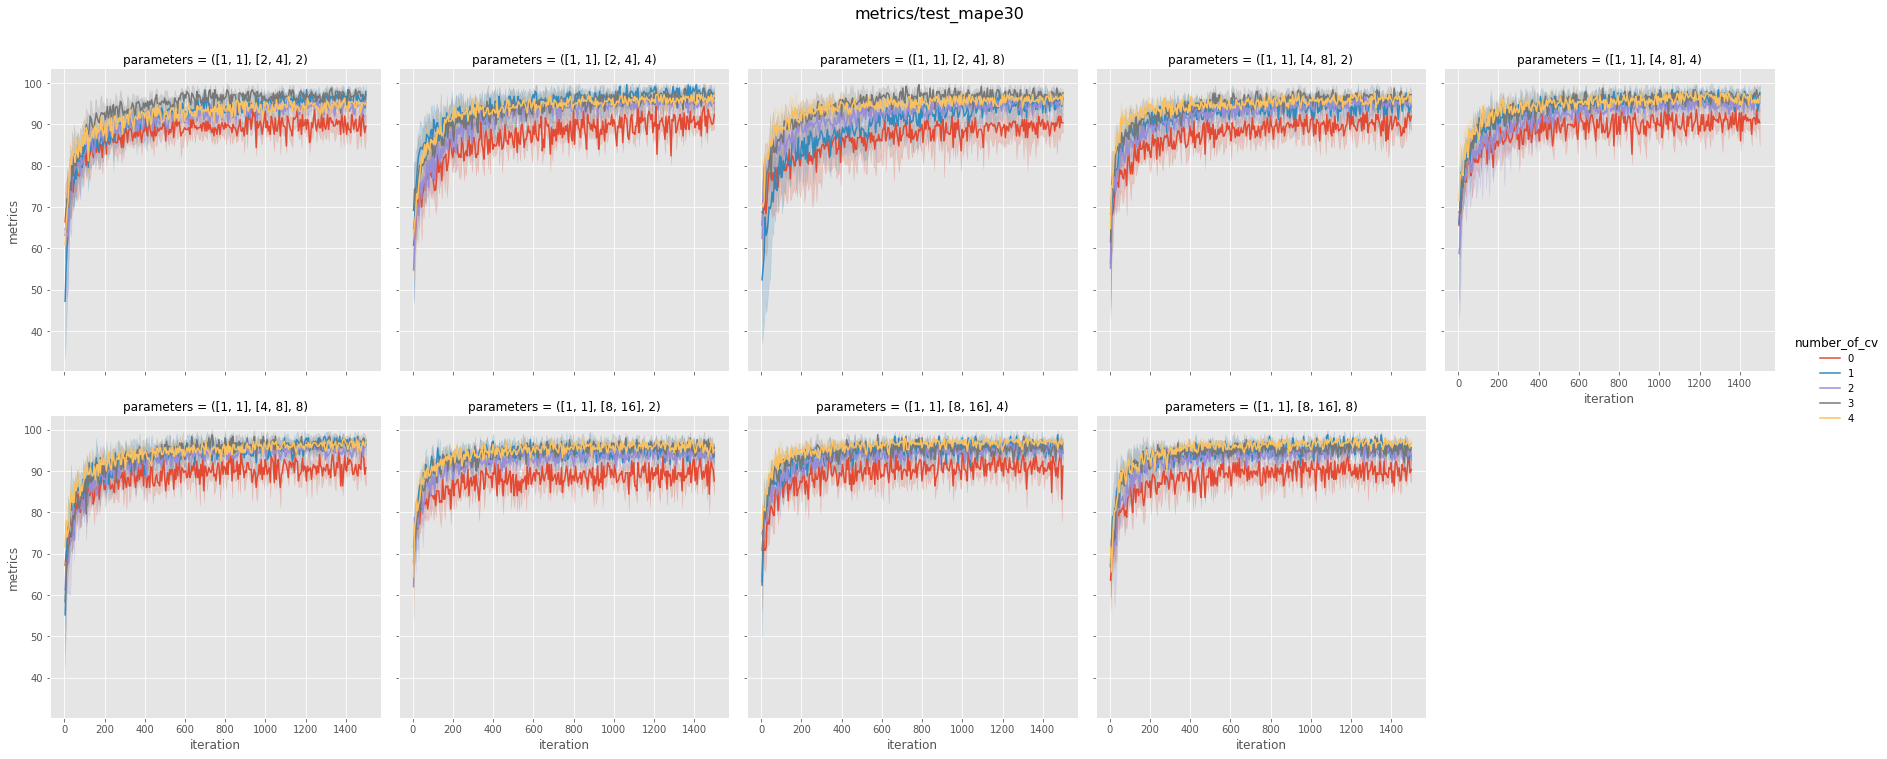

In [9]:
draw_dict = {'num_blocks': '[1, 1]'}
draw_history(research='research_2_block/', names=['test_mape30'], types_var=['metrics'],
             cross_val=cross_val, aggr=False, iter_start=1, draw_dict=draw_dict)

Now let's draw the same graph for second research.

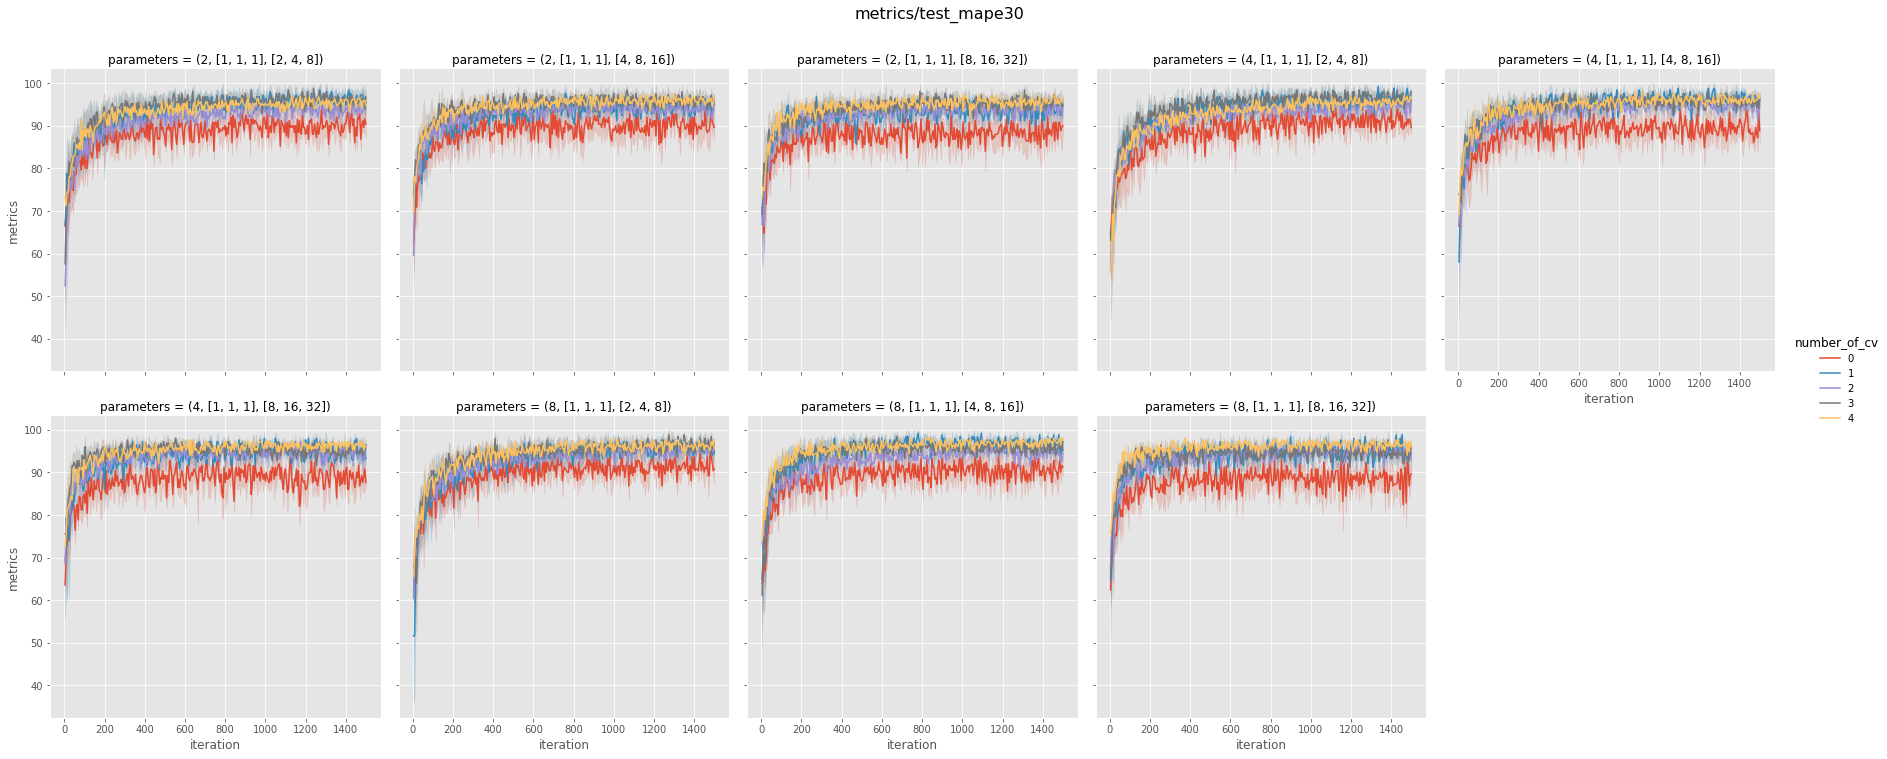

In [10]:
draw_dict = {'num_blocks': '[1, 1, 1]'}
draw_history(research='research_3_block/', names=['test_mape30'], types_var=['metrics'],
             cross_val=cross_val, aggr=False, iter_start=1, draw_dict=draw_dict)

It is hard to see the difference in this way, is't it? For detailed analysis let's calculate the average metric values and standard deviation of the metric. Print the results of the first research.

In [11]:
results = print_results_cv(research='research_2_block/', names=['test_mape30'],
                           cross_val=cross_val, types_var=['metrics'],
                           draw_dict=None, sort_by='test_mape30_mean')
results[0]

,test_mape30_0,test_mape30_1,test_mape30_2,test_mape30_3,test_mape30_4,test_mape30_mean,test_mape30_std
"([1, 1], [2, 4], 4)",91.009524,97.676190,95.161905,96.780952,96.190476,95.363810,2.325483
"([1, 1], [4, 8], 8)",91.238095,96.323810,95.104762,96.800000,96.342857,95.161905,2.040959
"([1, 1], [4, 8], 4)",90.895238,96.114286,95.009524,96.552381,96.000000,94.914286,2.071905
"([1, 1], [8, 16], 4)",90.647619,95.809524,95.028571,95.485714,96.971429,94.788571,2.167870
"([2, 2], [2, 4], 8)",91.600000,95.504762,94.114286,96.552381,96.133333,94.780952,1.791854
"([1, 1], [2, 4], 8)",89.980952,95.200000,95.504762,96.857143,96.209524,94.750476,2.453008
"([1, 1], [4, 8], 2)",90.285714,94.838095,95.104762,96.552381,96.171429,94.590476,2.245229
"([2, 2], [4, 8], 8)",90.704762,95.790476,94.819048,95.142857,96.171429,94.525714,1.968481
"([1, 1], [2, 4], 2)",89.695238,96.171429,94.190476,97.028571,94.780952,94.373333,2.544311
"([2, 2], [2, 4], 4)",90.133333,95.104762,94.952381,95.752381,95.371429,94.262857,2.082538


Print the results of the second research.

In [12]:
results = print_results_cv(research='research_3_block/', names=['test_mape30'],
                           cross_val=cross_val, types_var=['metrics'],
                           draw_dict=None, sort_by='test_mape30_mean')
results[0]

,test_mape30_0,test_mape30_1,test_mape30_2,test_mape30_3,test_mape30_4,test_mape30_mean,test_mape30_std
"(8, [1, 1, 1], [2, 4, 8])",91.561905,95.676190,95.333333,96.361905,96.228571,95.032381,1.774698
"(8, [1, 1, 1], [4, 8, 16])",90.476190,96.590476,94.647619,95.600000,97.219048,94.906667,2.381565
"(4, [1, 1, 1], [2, 4, 8])",91.104762,96.552381,94.742857,96.285714,95.752381,94.887619,1.990220
"(8, [2, 2, 2], [2, 4, 8])",90.000000,96.057143,94.285714,96.038095,96.419048,94.560000,2.397961
"(2, [1, 1, 1], [2, 4, 8])",90.533333,96.266667,93.771429,95.847619,95.600000,94.403810,2.115003
"(4, [1, 1, 1], [4, 8, 16])",89.428571,96.076190,94.342857,95.371429,96.076190,94.259048,2.497276
"(8, [2, 2, 2], [4, 8, 16])",90.152381,95.923810,94.323810,94.857143,95.923810,94.236190,2.133864
"(2, [1, 1, 1], [4, 8, 16])",90.285714,94.514286,93.847619,95.638095,95.885714,94.034286,2.015789
"(4, [1, 1, 1], [8, 16, 32])",88.761905,94.742857,94.495238,95.200000,96.342857,93.908571,2.650356
"(2, [2, 2, 2], [2, 4, 8])",90.285714,94.152381,94.057143,95.714286,95.180952,93.878095,1.901658


## Conclusion

As can be seen from the tables above, the best model is the one with following parameters:
* _Number of filers in block_ : $[2, 4, 8]$
* _Number of initial finters_ : $8$
* _Number of ResNet blocks_ : $[1, 1, 1].$

This model shows not the best average metric value, but it shows the best stability, that's why we chose this model.

Despite the fact that the chosen configuration is a best variant, it is useful, along with a point estimate, to obtain the distribution of the metric over 20 independent runs of the training procedure.

Firstly we should reconstruct pipelines with optimal parameters.

In [13]:
ds_train = Dataset(FilesIndex(path="./data_splited/train_isol/*"), batch_class=RadialBatch)
ds_test = Dataset(FilesIndex(path="./data_splited/train_isol/*"), batch_class=RadialBatch)

model_config['body/num_blocks'] = [1, 1, 1]
model_config['body/filters'] = [2, 4, 8]
model_config['initial_block/filters'] = 8

train_pipeline = create_train_pipeline(ResNet, model_config,
                                       prep_pipeline).run(B_SIZE, n_epochs=None, 
                                                          drop_last=True,
                                                          shuffle=True,
                                                          lazy=True)
test_pipeline = create_predict_pipeline(prep=prep_pipeline, 
                                        load_model=C('import_from')).run(B_SIZE, n_epochs=1, 
                                                                         drop_last=True,
                                                                         shuffle=True,
                                                                         lazy=True)

train_pipeline = train_pipeline << ds_train
test_pipeline = test_pipeline << ds_test

After it we can create a Research instance.

In [14]:
research = (Research()
            .add_pipeline(train_pipeline, variables='loss', name='train')
            .add_pipeline(test_pipeline, name='test', execute='%5',
                          run=True, import_from='train')
            .add_grid({})
            .add_function(get_mape30, returns='metrics', name='test_mape30',
                          execute='%5', pipeline='test')
            .add_function(get_ape, returns='metrics', name='test_ape',
                          execute=-1, pipeline='test')
            .add_function(save_model, execute=-1, pipeline='train',
                          model_name='model', path='saved_models/')
)

In [15]:
NUM_REPEAT = 20
NUM_ITERS = 1200
research_name = './model_estimation/'

research.run(n_reps=NUM_REPEAT, n_iters=NUM_ITERS, name=research_name, bar=True,
             workers=8, gpu=[0, 1, 2, 3, 4, 5, 6, 7])

Let's check the distribution of metrics values of the trained models.

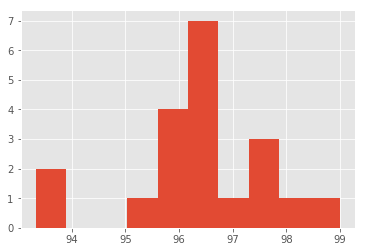

In [16]:
res_table = Research().load(research_name).load_results()
maximum = np.max(res_table['iteration'])
all_metrics = np.array(res_table[(res_table['iteration']==maximum) &
                                 (res_table['name']=='test_mape30')]['metrics'],
                       dtype=np.float32)
plt.hist(all_metrics)
plt.show()

Now let's calculate the mean value of the metrics and std for the last 50 iterations.

In [17]:
df = Research().load(research_name).load_results(use_alias=True)
print_results_research(df, 'test_mape30', 'metrics',  average_repetitions=True,
                       sort_by='test_mape30_mean', n_last=50)

,test_mape30_mean,test_mape30_std
,96.52,0.308601


And draw the distribution of absolute error on test data.

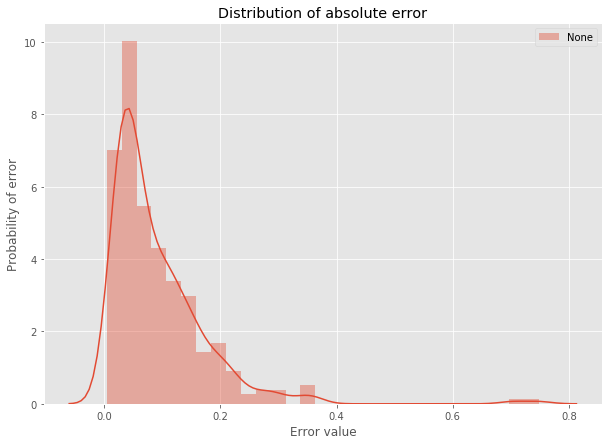

In [18]:
draw_hisogram(research=research_name, names='test_ape',
              type_var='metrics', cross_val=None)